# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

### LSA:
Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

LSA is quick and efficient to use, but it does have a few primary drawbacks:
- lack of interpretable embeddings (we don’t know what the topics are, and the components may be arbitrarily positive/negative)
- need for really large set of documents and vocabulary to get accurate results
- less efficient representation

### pLSA:
pLSA, or Probabilistic Latent Semantic Analysis, uses a probabilistic method instead of SVD to tackle the problem. The core idea is to find a probabilistic model with latent topics that can generate the data we observe in our document-term matrix. In particular, we want a model $P(D,W)$ such that for any document $d$ and word $w$, $P(d,w)$ corresponds to that entry in the document-term matrix.

Recall the basic assumption of topic models: 
- each document consists of a mixture of topics, and each topic consists of a collection of words. 

pLSA adds a probabilistic spin to these assumptions:
- given a document $d$, topic $z$ is present in that document with probability $P(z|d)$
- given a topic $z$, word $w$ is drawn from $z$ with probability $P(w|z)$.

Formally, the joint probability of seeing a given document and word together is:

$$P(D|W) = P(D) \sum_{Z}P(Z|D)P(W|Z)$$

Intuitively, the right-hand side of this equation is telling us how likely it is see some document, and then based upon the distribution of topics of that document, how likely it is to find a certain word within that document.

In this case, P(D), P(Z|D), and P(W|Z) are the parameters of our model. P(D) can be determined directly from our corpus. P(Z|D) and P(W|Z) are modeled as multinomial distributions, and can be trained using the expectation-maximization algorithm (EM), a method of finding the likeliest parameter estimates for a model which depends on unobserved, latent variables (in our case, the topics).

Interestingly, P(D,W) can be equivalently parameterized using a different set of 3 parameters:
$$P(D|W) =  \sum_{Z}P(Z)P(D|Z)P(W|Z)$$

We can understand this equivalency by looking at the model as a generative process. In our first parameterization, we were starting with the document with P(d), and then generating the topic with P(z|d), and then generating the word with P(w|z). In this parameterization, we are starting with the topic with P(z), and then independently generating the document with P(d|z) and the word with P(w|z).

The reason this new parameterization is so interesting is because we can see a direct parallel between our pLSA model our LSA model: $A = USV^{T}$, where the probability of our topic P(Z) corresponds to the diagonal matrix of our singular topic probabilities, the probability of our document given the topic P(D|Z) corresponds to our document-topic matrix U, and the probability of our word given the topic P(W|Z) corresponds to our term-topic matrix V.

Although it looks quite different and approaches the problem in a very different way, pLSA really just adds a probabilistic treatment of topics and words on top of LSA. It is a far more flexible model, but still has a few problems. In particular:
- Because we have no parameters to model P(D), we don’t know how to assign probabilities to new documents
- The number of parameters for pLSA grows linearly with the number of documents we have, so it is prone to overfitting

pLSA is rarely used on its own. In general, when people are looking for a topic model beyond the baseline performance LSA gives, they turn to LDA. LDA, the most common type of topic model, extends PLSA to address these issues.

### LDA:
LDA stands for Latent Dirichlet Allocation. LDA is a Bayesian version of pLSA. In particular, it uses dirichlet priors for the document-topic and word-topic distributions, lending itself to better generalization.

[good intuitive explanation 1](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution)

[good intuitive explanation 2](https://stats.stackexchange.com/questions/244917/what-exactly-is-the-alpha-in-the-dirichlet-distribution) 

As a brief overview, however, we can think of dirichlet as a “distribution over distributions.” In essence, it answers the question: “given this type of distribution, what are some actual probability distributions I am likely to see?” Or, what a dirichlet distribution provides: a way of sampling probability distributions of a specific type. 

From a dirichlet distribution Dir(α), we draw a random sample representing the topic distribution, or topic mixture, of a particular document. This topic distribution is θ. From θ, we select a particular topic Z based on the distribution.
Next, from another dirichlet distribution Dir(𝛽), we select a random sample representing the word distribution of the topic Z. This word distribution is φ. From φ, we choose the word w.

LDA typically works better than pLSA because it can generalize to new documents easily. 
- In pLSA, the document probability is a fixed point in the dataset. If we haven’t seen a document, we don’t have that data point. 
- In LDA, the dataset serves as training data for the dirichlet distribution of document-topic distributions. If we haven’t seen a document, we can easily sample from the dirichlet distribution and move forward from there.

In [1]:
import pickle
filepath = r"C:\Users\xxxli\Desktop\ResumeProjects\Data_Science_Applications\LSA_Recommender_DS7\raw_text_dataset.pickle"
raw_text_dataset = pickle.load(open(filepath, "rb"))
corpus_train, labels_train = raw_text_dataset[0], raw_text_dataset[1] 
corpus_test, labels_test = raw_text_dataset[2], raw_text_dataset[3]
print('Data Importing ...')
corpus = corpus_train + corpus_test
corpus_train = corpus
print('number of documents:', len(corpus_train))

Data Importing ...
number of documents: 9601


In this notebook, I am applying Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) on our 10K article corpus and extract additive models of the topic structure of the corpus. The output is a plot of topics, each represented as bar plot using top few words based on weights.

### NMF
Non-negative Matrix Factorization, similar with SVD in LSA, is another techniques for dimension reduction. It is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.

In [2]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
n_samples = len(corpus_train) # use all artcles avaliable
n_features = 10000 # original number of words extracted
n_components = 10 # after dimension reduction, 10 PCs left
n_top_words = 20 # top 20 most important words in each PC

Extracting tf-idf features for NMF...
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=9601 and n_features=10000...


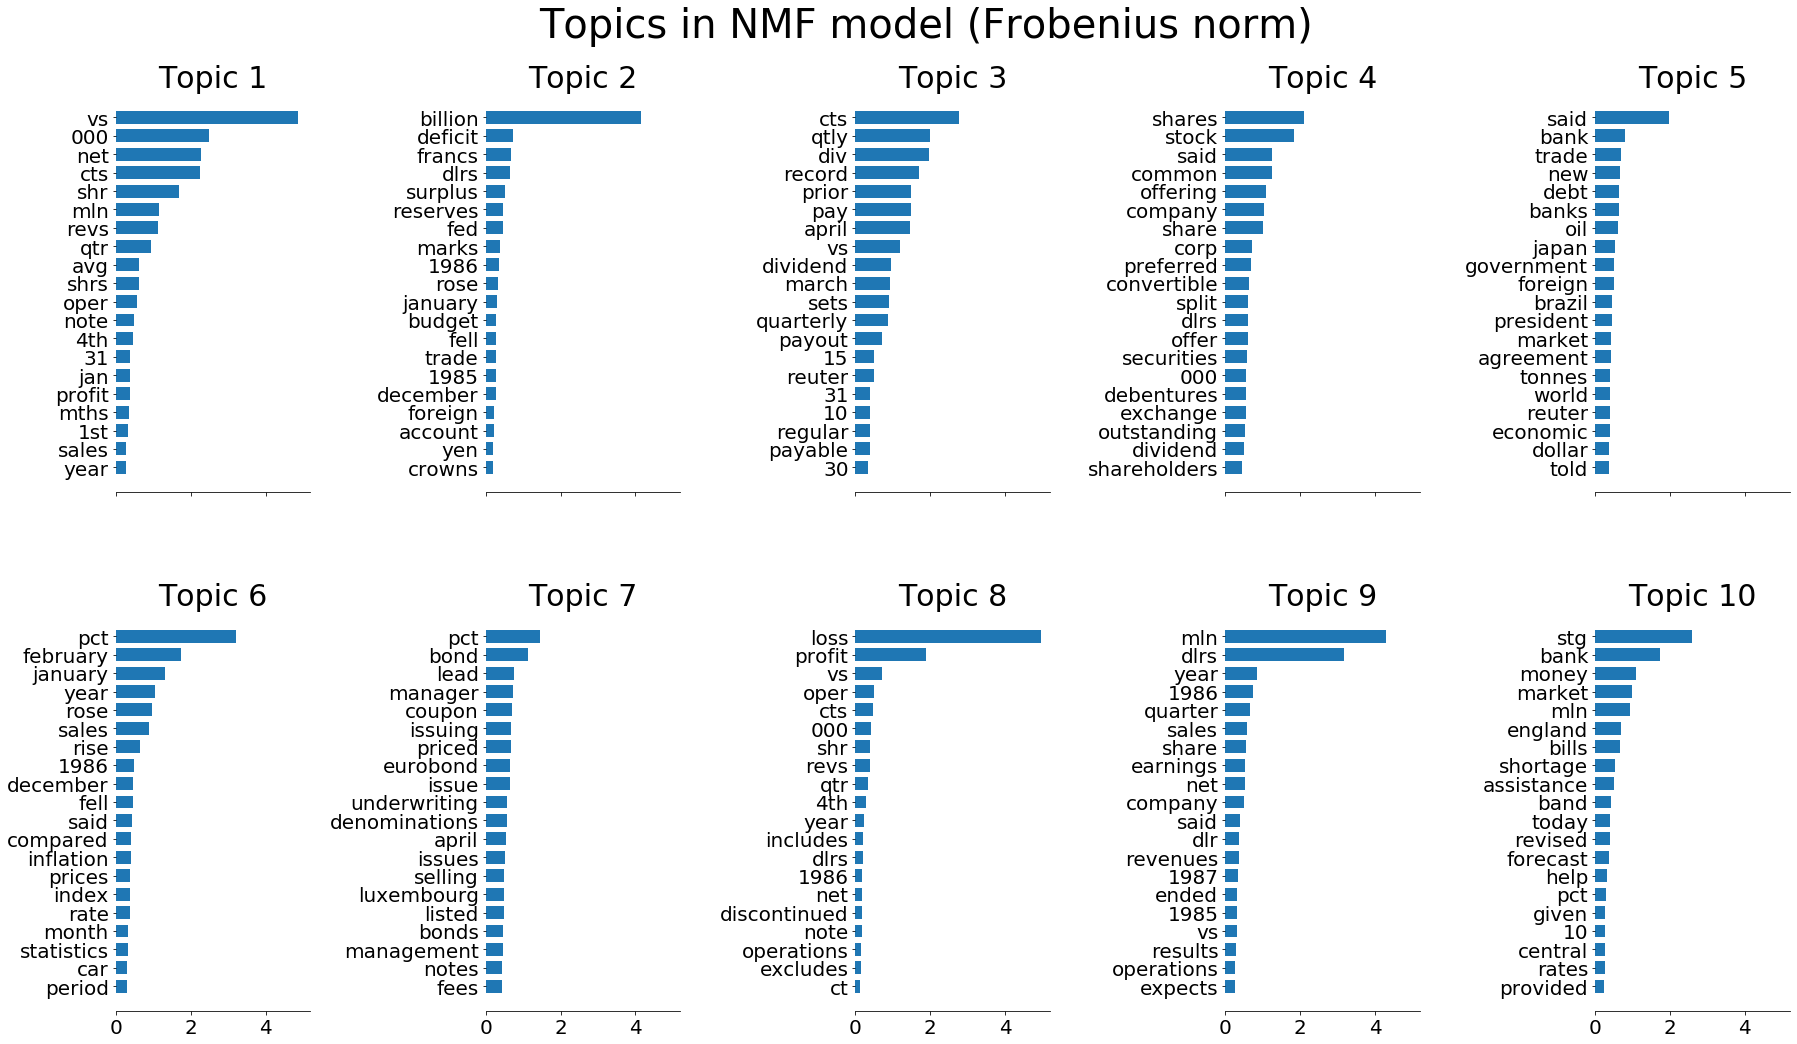

done.


 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=9601 and n_features=10000...


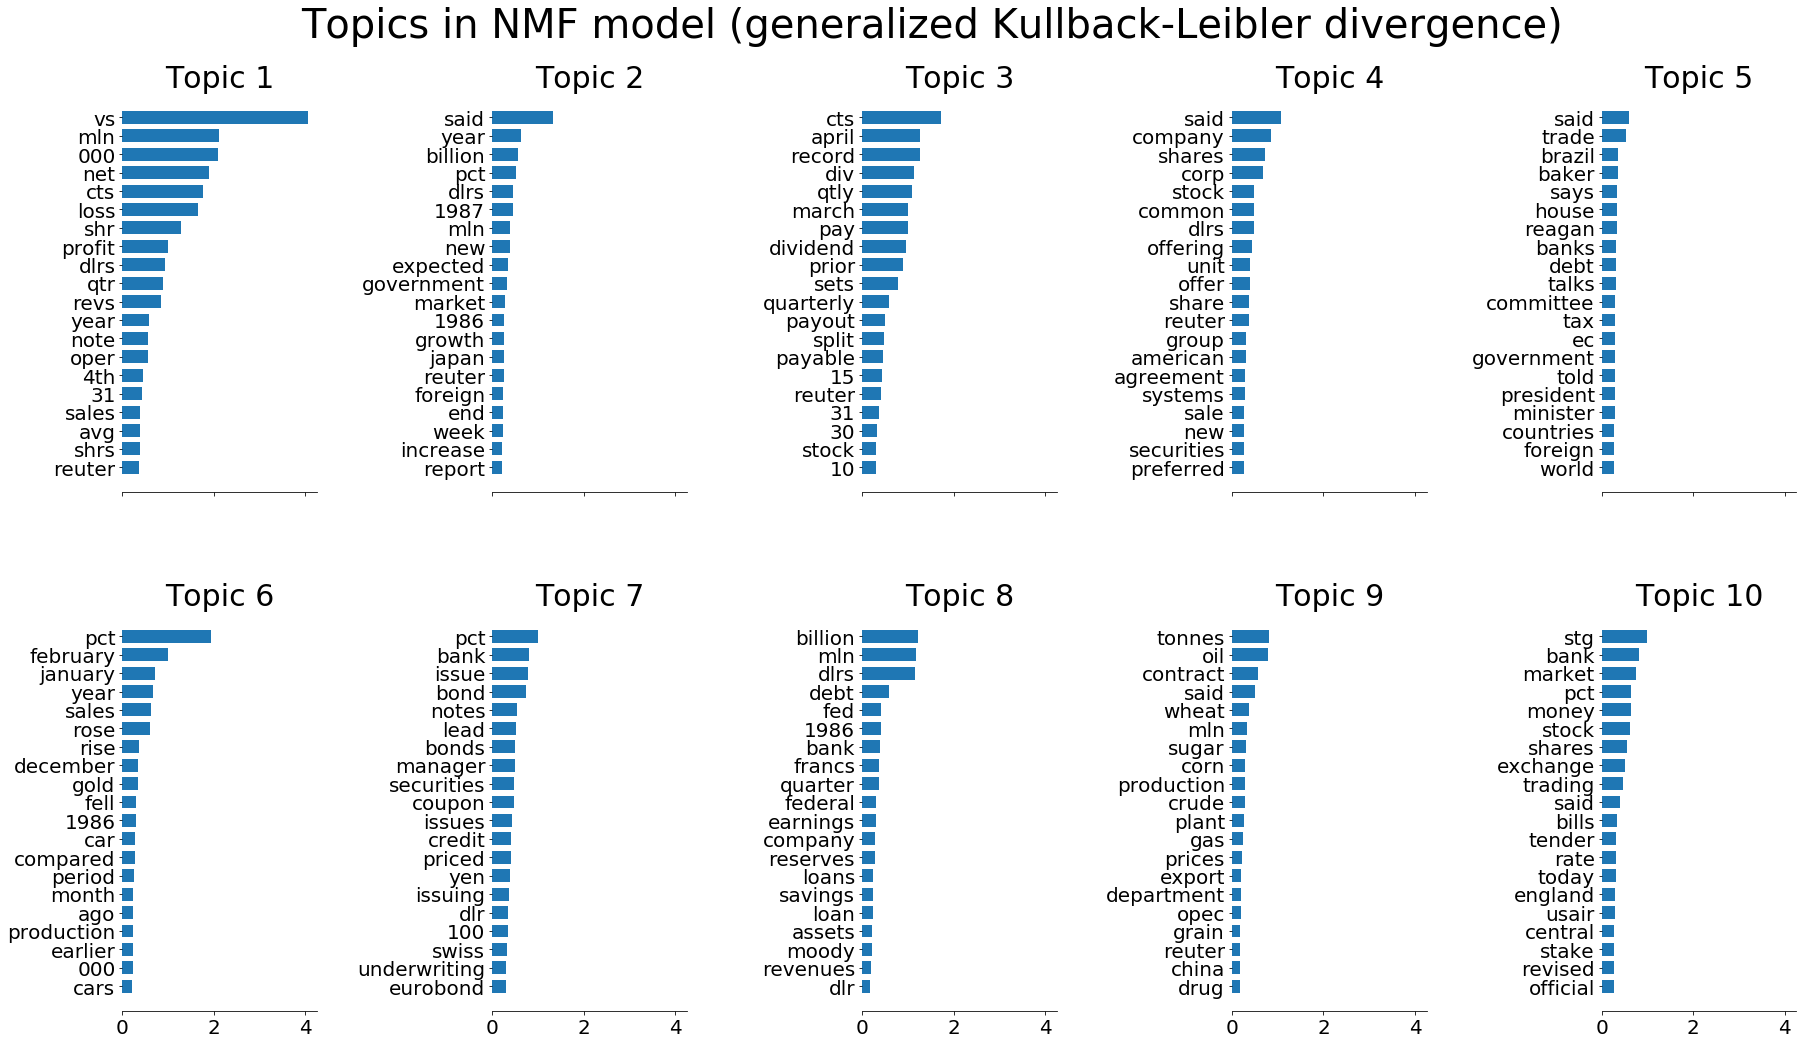

done.
Extracting tf features for LDA...


 Fitting LDA models with tf features, n_samples=9601 and n_features=10000...


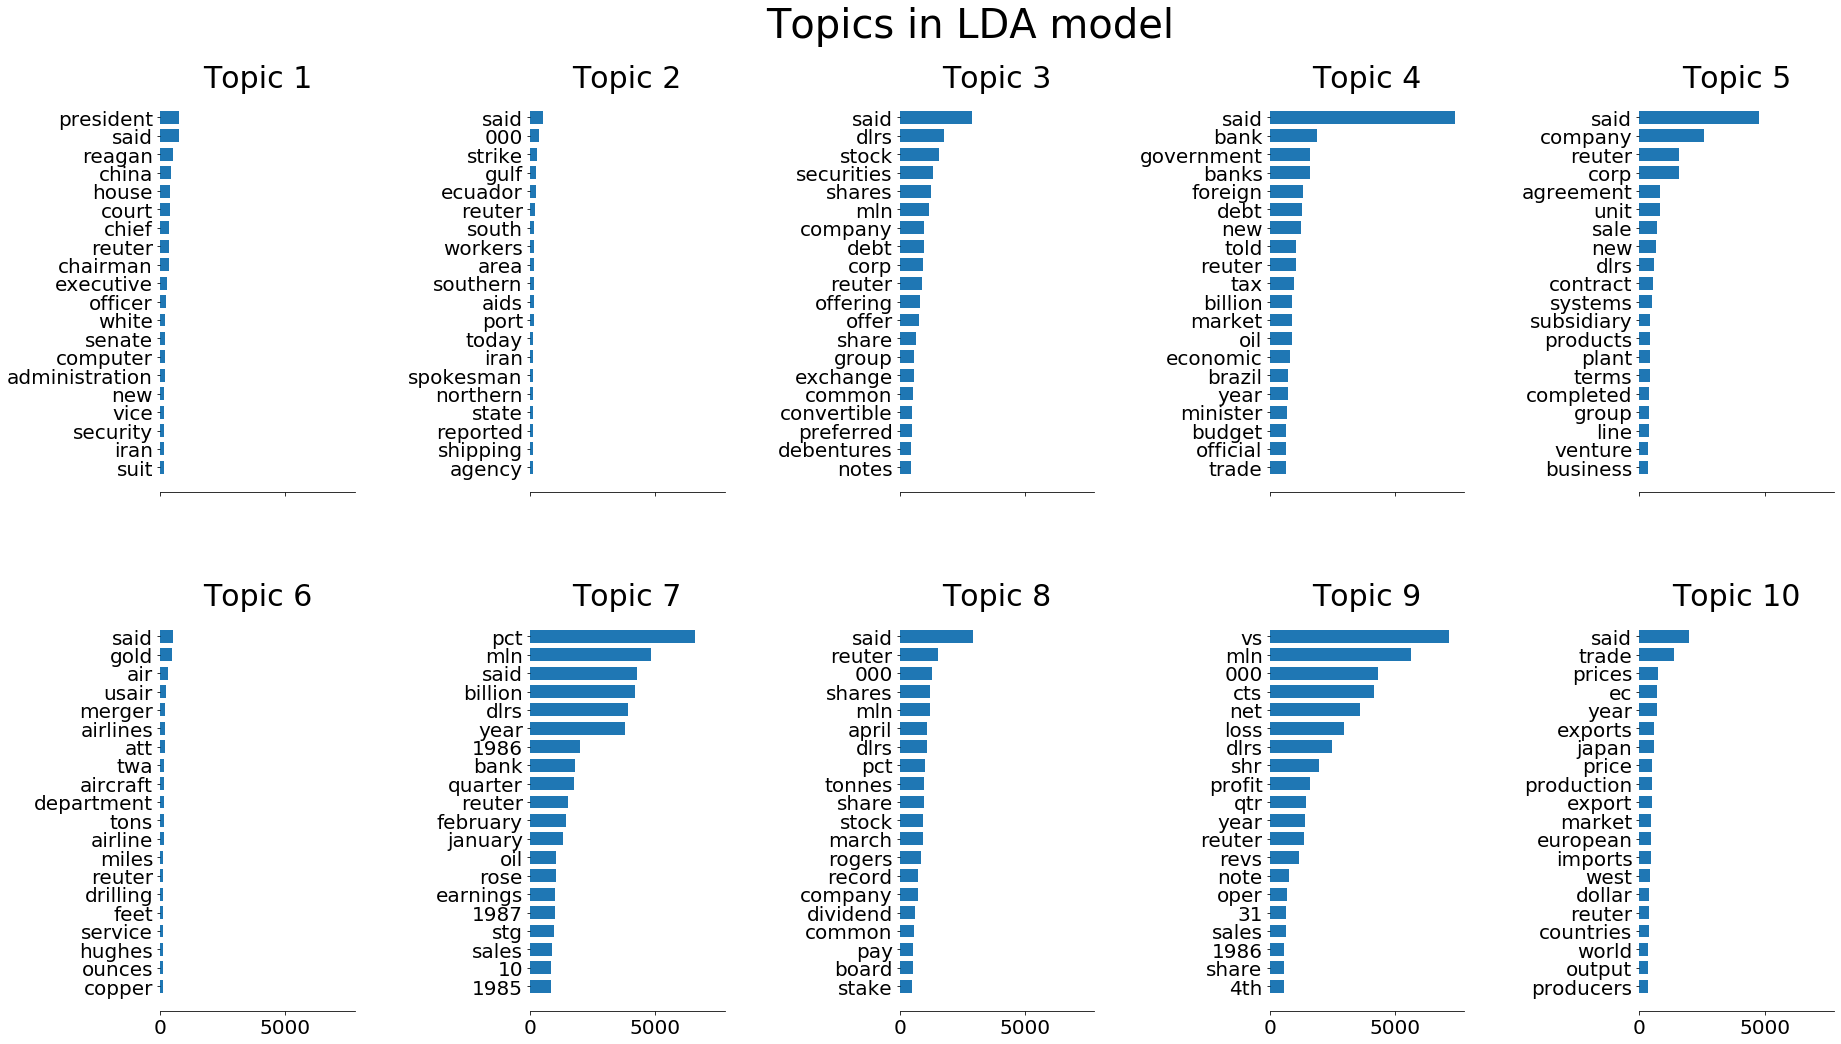

In [5]:
# MODEL 1
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus_train)

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')
print("done.")


# MODEL 2
# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')
print("done.")


# MODEL 3
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(corpus_train)
print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')